# Library Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Dataset Generation

In [2]:
def generate_dataset(N=1000, features=3, classes=5):
    dataset = []

    for c in range(classes):
        samples = np.random.randn(N//classes, features) + np.random.randn(features)
        label = np.full((N//classes, 1), c)
        dataset.append(np.concatenate([samples, label], axis=1))

    dataset = np.concatenate(dataset, axis=0)
    np.random.shuffle(dataset)
    return dataset

In [3]:
def generate_spiral(n_points=2000, classes=5):
    X = []
    y = []
    for class_id in range(classes):
        ix = range(n_points//classes)
        r = np.linspace(0.0, 1, n_points//classes)     # radius
        t = np.linspace(class_id*4, class_id*4 + 4, n_points//classes) + np.random.randn(n_points//classes)*0.2
        x1 = r * np.sin(t)
        x2 = r * np.cos(t)
        x3 = r * np.sin(t*0.5) # extra feature adds complexity
        X.append(np.c_[x1, x2, x3])
        y.append(np.full(n_points//classes, class_id))
    return np.vstack(X), np.hstack(y)


In [4]:
# dataset = generate_dataset(N=1000, features=3, classes=5)

In [5]:
dataset = generate_spiral()

In [6]:
dataset[0].shape

(2000, 3)

In [7]:
dataset[1].shape

(2000,)

In [8]:
# generate data
X, y = generate_spiral(n_points=2000, classes=5)

# shuffle
idx = np.random.permutation(X.shape[0])
X = X[idx]
y = y[idx]

In [9]:
X[:50], y[:50]

(array([[-4.44151226e-01,  1.97826285e-01,  2.64782304e-01],
        [ 3.03558470e-01, -4.39125974e-01,  5.09607692e-01],
        [-3.67557039e-01,  3.48147592e-01,  2.00062179e-01],
        [-4.33041489e-01, -7.97251906e-01,  8.79334069e-01],
        [ 9.90304902e-01, -9.64171378e-02, -7.36862914e-01],
        [ 4.73011239e-01, -2.06921440e-01,  4.32080858e-01],
        [-5.96013621e-03,  4.97697077e-02, -2.98536760e-03],
        [ 2.47773989e-01, -8.36245652e-01,  8.63150001e-01],
        [-4.56294825e-02, -7.78370266e-02,  8.70733656e-02],
        [ 1.17890964e-01,  8.33812326e-01, -5.90911420e-02],
        [-1.08943049e-02, -4.37775881e-02,  4.47777393e-02],
        [ 2.65887630e-01, -6.76436827e-01,  7.14110926e-01],
        [ 7.31730665e-01,  4.60662577e-01, -4.17924939e-01],
        [ 5.08764001e-01, -2.84031407e-03,  3.60758887e-01],
        [ 3.58193941e-01, -5.01817039e-01,  5.87160198e-01],
        [ 1.50993334e-01,  6.39045546e-01, -7.60075788e-02],
        [ 6.15705494e-01

In [10]:
X_train, y_train = X[:800], y[:800].astype(int)
X_test, y_test = X[800:], y[800:].astype(int)

In [11]:
def one_hot(y_true):
    one_hot_y = np.zeros((y_true.shape[0], 5))
    one_hot_y[np.arange(y_true.shape[0]), y_true] = 1
    return one_hot_y

In [12]:
y_train_one_hot = one_hot(y_train)
y_test_one_hot = one_hot(y_test)

In [13]:
y_train_one_hot[:5]

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [14]:
y_test_one_hot[:5]

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [15]:
def cross_entropy(y_true, y_pred):
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-9), axis=1))


In [16]:
class NeuralNetwork(object):
    def __init__(self):
        # neuron size per layer
        self.inputLayerNeurons = 3
        self.hiddenLayer1Neurons = 8
        self.hiddenLayer2Neurons = 6
        self.hiddenLayer3Neurons = 4
        self.outputLayerNeurons = 5

        self.learning_rate = 0.01
        self.error = []
        self.val_error = []

        # weights (He initialization)
        self.W1 = np.random.randn(self.inputLayerNeurons, self.hiddenLayer1Neurons) * np.sqrt(2/self.inputLayerNeurons)
        self.W2 = np.random.randn(self.hiddenLayer1Neurons, self.hiddenLayer2Neurons) * np.sqrt(2/self.hiddenLayer1Neurons)
        self.W3 = np.random.randn(self.hiddenLayer2Neurons, self.hiddenLayer3Neurons) * np.sqrt(2/self.hiddenLayer2Neurons)
        self.W4 = np.random.randn(self.hiddenLayer3Neurons, self.outputLayerNeurons) * np.sqrt(2/self.hiddenLayer3Neurons)

        # biases (zeros)
        self.b1 = np.zeros((self.hiddenLayer1Neurons,))
        self.b2 = np.zeros((self.hiddenLayer2Neurons,))
        self.b3 = np.zeros((self.hiddenLayer3Neurons,))
        self.b4 = np.zeros((self.outputLayerNeurons,))

    def relu(self, x, der=False):
        if der:
            return (x > 0).astype(float)
        return np.maximum(0, x)

    def softmax(self, z):
      z = z - np.max(z, axis=1, keepdims=True)
      e_z = np.exp(z)
      return e_z / np.sum(e_z, axis=1, keepdims=True)


    def feedForward(self, X):
        # X: (N,3)
        self.z1 = np.dot(X, self.W1) + self.b1      # (N,10)
        self.h1 = self.relu(self.z1)

        self.z2 = np.dot(self.h1, self.W2) + self.b2  # (N,10)
        self.h2 = self.relu(self.z2)

        self.z3 = np.dot(self.h2, self.W3) + self.b3  # (N,10)
        self.h3 = self.relu(self.z3)

        self.z4 = np.dot(self.h3, self.W4) + self.b4  # (N,5)
        self.ouput = self.softmax(self.z4)            # (N,5)

        return self.ouput

    def backPropagation(self, X, y_true):
        m = X.shape[0]

        # output layer
        dz4 = self.ouput - y_true                    # (N,5)
        dW4 = np.dot(self.h3.T, dz4) / m             # (10,5)
        db4 = np.sum(dz4, axis=0) / m                # (5,)

        # hidden layers
        # chain rule: dz = dh * relu'(z)
        # where dh = dz * W^T
        # and relu'(z) = 1 if z > 0 else 0
        dh3 = np.dot(dz4, self.W4.T)                 # (N,10)
        dz3 = dh3 * self.relu(self.z3, der=True)     # (N,10)
        dW3 = np.dot(self.h2.T, dz3) / m             # (10,10)
        db3 = np.sum(dz3, axis=0) / m

        dh2 = np.dot(dz3, self.W3.T)                 # (N,10)
        dz2 = dh2 * self.relu(self.z2, der=True)
        dW2 = np.dot(self.h1.T, dz2) / m             # (10,10)
        db2 = np.sum(dz2, axis=0) / m

        dh1 = np.dot(dz2, self.W2.T)                 # (N,10)
        dz1 = dh1 * self.relu(self.z1, der=True)
        dW1 = np.dot(X.T, dz1) / m                   # (3,10)
        db1 = np.sum(dz1, axis=0) / m

        # gradient descent step
        self.W4 -= self.learning_rate * dW4
        self.b4 -= self.learning_rate * db4

        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3

        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1

    def train(self, X, y):
        output = self.feedForward(X)
        loss = cross_entropy(y, output)
        self.error.append(loss)
        self.backPropagation(X, y)
        return loss

    def evaluate(self, X, y_true_one_hot):
      y_pred = self.feedForward(X)
      pred_classes = np.argmax(y_pred, axis=1)
      true_classes = np.argmax(y_true_one_hot, axis=1)
      accuracy = np.mean(pred_classes == true_classes)

      # confusion matrix
      num_classes = y_true_one_hot.shape[1]
      cm = np.zeros((num_classes, num_classes), dtype=int)
      for t, p in zip(true_classes, pred_classes):
          cm[t, p] += 1

      return {
          "accuracy": accuracy,
          "confusion_matrix": cm,
          "predicted_classes": pred_classes,
          "true_classes": true_classes,
          "probabilities": y_pred
      }

    def predict(self, X):
      pred = self.feedForward(X)
      return np.argmax(pred, axis=1)

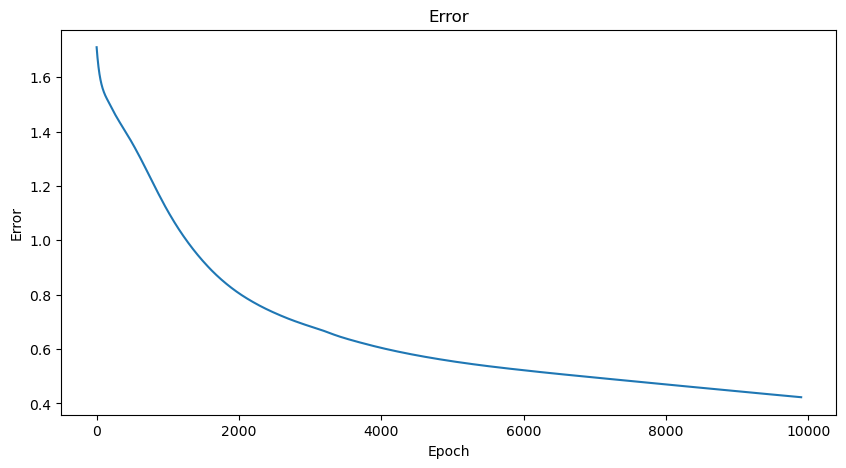

Epoch:  9900 Loss:  0.423009444328243


In [17]:
from IPython import display

NN = NeuralNetwork()
for i in range(10000):
    NN.train(X_train, y_train_one_hot)
    loss = NN.error
    display.clear_output(wait=True)
    if i % 100 == 0:
      plt.figure(figsize=(10, 5))
      plt.plot(loss)
      plt.title("Error")
      plt.xlabel("Epoch")
      plt.ylabel("Error")
      plt.show()
      print("Epoch: ", i, "Loss: ", loss[-1])

In [18]:
NN.evaluate(X_test, y_test_one_hot)

{'accuracy': np.float64(0.85),
 'confusion_matrix': array([[201,   0,   0,  28,   0],
        [  0, 190,   0,   1,  52],
        [  0,   0, 232,   2,   0],
        [ 33,   0,  14, 211,   0],
        [  0,  50,   0,   0, 186]]),
 'predicted_classes': array([1, 1, 0, ..., 2, 4, 2], shape=(1200,)),
 'true_classes': array([1, 4, 0, ..., 2, 4, 2], shape=(1200,)),
 'probabilities': array([[1.04709056e-05, 6.57068436e-01, 2.70555540e-03, 4.53654096e-02,
         2.94850128e-01],
        [6.04162312e-03, 5.65806105e-01, 2.23495879e-03, 1.07775352e-02,
         4.15139778e-01],
        [7.53200429e-01, 3.24396476e-03, 4.15530248e-04, 2.32612879e-01,
         1.05271976e-02],
        ...,
        [1.99834558e-16, 9.00872951e-03, 9.90991105e-01, 1.64713515e-07,
         6.73929039e-10],
        [3.61638899e-06, 2.98916014e-01, 1.23059852e-04, 6.61874535e-03,
         6.94338564e-01],
        [2.42027383e-17, 9.25702358e-09, 9.99999990e-01, 4.48169606e-10,
         8.06409017e-19]], shape=(1200, 5

In [19]:
X.shape

(2000, 3)

In [20]:
y[:10]

array([4, 0, 4, 0, 1, 0, 3, 3, 4, 4])

In [21]:
print(NN.predict(np.array(X[:10])))

[4 0 4 0 1 0 3 3 1 4]
